In [1]:
#ORIGINAL FROM https://github.com/mihaidusmanu/d2-net

In [2]:
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


import numpy as np

import os

import torch

from scipy.io import loadmat

from tqdm import tqdm_notebook as tqdm
import random
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2
import imageio

In [3]:
visualize = False 
plot_idx = [80, 55, 23] # which images should be plottet
use_ransac = False

In [4]:
# delete cache of our-model
file = 'cache/our-model.npy'
if os.path.exists(file):
    os.remove(file)
    print('file removed')

In [5]:
%matplotlib inline

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

/home/witi/anaconda3/envs/dl2/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
# Add new methods here.
# methods = ['hesaff', 'hesaffnet', 'delf', 'delf-new', 'superpoint', 'd2-net', 'd2-net-trained']
# names = ['Hes. Aff. + Root-SIFT', 'HAN + HN++', 'DELF', 'DELF New', 'SuperPoint', 'D2-Net', 'D2-Net Trained']
# colors = ['black', 'orange', 'red', 'red', 'blue', 'purple', 'purple']
# linestyles = ['-', '-', '-', '--', '-', '-', '--']
methods = ['d2enc_no_att','our_enc_d2net_localization','cfe64_multi_attention_model2_d2netloss', 'cfe64_multi_attention_model2_d2netloss_backprop', 'cfe64_multi_attention_model_distinctiveness+_loss', 'cfe64_multi_attention_model_distinctiveness+_lossN8_l1', 'cfe64_multi_attention_model_distinctiveness+_lossN32_l1', 'cfe64_multi_attention_model2_distinctiveness+_lossN16_lambda01_sm_lowmargin_SHARED', 'cfe64_multi_attention_model2_distinctiveness+_lossN16_lambda01_lowmargin', 'cfe64_multi_attention_model2_distinctiveness+_lossN8_lambda01_sm_SHARED', 'cfe64_multi_attention_model2_distinctiveness+_lossN8_lambda01_sm', 'cfe64_multi_attention_model2_distinctiveness+_lossN8_lambda1', 'cfe64_multi_attention_model2_distinctiveness+_lossN2_lambda05_sm_SHARED', 'cfe64_multi_attention_model2_distinctiveness+_lossN2_lambda05_sm', 'cfe64_multi_attention_model2_distinctiveness+_lossN64_lambda1', 'cfe64_multi_attention_model2_distinctiveness+_lossN32_lambda1', 'cfe64_multi_attention_model2_distinctiveness+_lossN16_lambda01_sm', 'cfe64_multi_attention_model2_distinctiveness+_loss']
names = ['d2net_encoder','our_enc_d2net_localization','ma2_d2netloss', 'ma2_d2netloss_backprop', 'ma_dist+_loss', 'ma_dist+_lossN8_l1', 'ma_dist+_lossN32_l1', 'ma2_dist+_lossN16_lambda01_sm_lowmargin_shared', 'ma2_dist+_lossN16_lambda01_lowmargin', 'ma2_dist+_lossN8_lambda01_sm_shared', 'ma2_dist+_lossN8_lambda01_sm', 'ma2_dist+_lossN8_lambda1', 'ma2_dist+_lossN2_lambda05_sm_shared', 'ma2_dist+_lossN2_lambda05_sm', 'ma2_dist+_lossN64_lambda1', 'ma2_dist+_lossN32_lambda1', 'ma2_dist+_lossN16_lambda01_sm', 'ma2_dist+_loss']
colors = ['magenta','yellow',
          'black', 'orange',  'red', 'blue', 'brown', 'purple', 'green','pink', 'magenta','yellow',
          'black', 'orange',  'red', 'blue', 'brown', 'purple', 'green','pink']
linestyles = ['-','-','-','-','-','-','-','-','-','-','--','--','--','--','--','--','--','--','--','--']

In [8]:
print(len(methods), len(names))

18 18


In [9]:
# Change here if you want to use top K or all features.
# top_k = 2000
top_k = None 

In [10]:
n_i = 52
n_v = 56

In [11]:
dataset_path = './hpatches-sequences-release'

In [12]:
lim = [1, 15]
rng = np.arange(lim[0], lim[1] + 1)

In [13]:
def mnn_matcher(descriptors_a, descriptors_b):
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    return matches.t().data.cpu().numpy()

In [14]:
def read_image(path, index):
    path = os.path.join(path, f"{index}.ppm")
    image = imageio.imread(os.path.join(dataset_path, path))
    if len(image.shape) == 2:
        image = image[:, :, np.newaxis]
        image = np.repeat(image, 3, -1)
    return image

In [15]:
def benchmark_features(read_feats):
    seq_names = sorted(os.listdir(dataset_path))

    n_feats = []
    n_matches = []
    seq_type = []
    i_err = {thr: 0 for thr in rng}
    v_err = {thr: 0 for thr in rng}

    for seq_idx, seq_name in tqdm(enumerate(seq_names), total=len(seq_names)):
        keypoints_a, descriptors_a = read_feats(seq_name, 1)
        n_feats.append(keypoints_a.shape[0])

##
        axs = None 
        image1_np = None
        if visualize and seq_idx in plot_idx:
            _, axs = plt.subplots(5,1, figsize=(20, 20))
            image1_np = read_image(seq_name, 1)
##/
        for im_idx in range(2, 7):
            keypoints_b, descriptors_b = read_feats(seq_name, im_idx)
            n_feats.append(keypoints_b.shape[0])

            matches = mnn_matcher(
                torch.from_numpy(descriptors_a).to(device=device), 
                torch.from_numpy(descriptors_b).to(device=device)
            )

            image2_np = None
            
            kpa = keypoints_a[matches[:, 0], : 2] 
            kpb = keypoints_b[matches[:, 1], : 2]
            nm = matches.shape[0]
            if use_ransac:
                np.random.seed(0)
                model, inliers = ransac(
                    (kpa, kpb),
                    ProjectiveTransform, min_samples=4,
                    residual_threshold=4, max_trials=10000
                )
                n_inliers = np.sum(inliers)
                nm = n_inliers
                print('Number of inliers: %d.' % n_inliers)
                kpa = kpa[inliers]
                kpb = kpb[inliers]
            if visualize and seq_idx in plot_idx:
                image2_np = read_image(seq_name, im_idx)
                #matches = match_descriptors(descriptors_a, descriptors_b, cross_check=True)
                #matches = mnn_matcher(
                #    torch.from_numpy(descriptors_a).to(device=device), 
                #    torch.from_numpy(descriptors_b).to(device=device)
                #)
                keypoints_left = keypoints_a[matches[:, 0], : 2]
                keypoints_right = keypoints_b[matches[:, 1], : 2]
                np.random.seed(0)
                model, inliers = ransac(
                    (keypoints_left, keypoints_right),
                    ProjectiveTransform, min_samples=4,
                    residual_threshold=4, max_trials=10000
                )
                n_inliers = np.sum(inliers)
                print('Number of inliers: %d.' % n_inliers)
                inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
                inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
                placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
                image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

                #print(keypoints_left[inliers])
                axs[im_idx-2].imshow(image3)

          
            homography = np.loadtxt(os.path.join(dataset_path, seq_name, "H_1_" + str(im_idx)))
            
            pos_a = kpa
            pos_a_h = np.concatenate([pos_a, np.ones([nm, 1])], axis=1)
            pos_b_proj_h = np.transpose(np.dot(homography, np .transpose(pos_a_h)))
            pos_b_proj = pos_b_proj_h[:, : 2] / pos_b_proj_h[:, 2 :]

            pos_b = kpb

            dist = np.sqrt(np.sum((pos_b - pos_b_proj) ** 2, axis=1))

            n_matches.append(nm)
            seq_type.append(seq_name[0])
            
            if dist.shape[0] == 0:
                dist = np.array([float("inf")])
            
            for thr in rng:
                if seq_name[0] == 'i':
                    i_err[thr] += np.mean(dist <= thr)
                else:
                    v_err[thr] += np.mean(dist <= thr)
        
        if visualize and seq_idx in plot_idx:
            print(seq_name)
            plt.show()

    
    seq_type = np.array(seq_type)
    n_feats = np.array(n_feats)
    n_matches = np.array(n_matches)
    
    return i_err, v_err, [seq_type, n_feats, n_matches]

In [16]:
def summary(stats):
    seq_type, n_feats, n_matches = stats
    print('# Features: {:f} - [{:d}, {:d}]'.format(np.mean(n_feats), np.min(n_feats), np.max(n_feats)))
    print('# Matches: Overall {:f}, Illumination {:f}, Viewpoint {:f}'.format(
        np.sum(n_matches) / ((n_i + n_v) * 5), 
        np.sum(n_matches[seq_type == 'i']) / (n_i * 5), 
        np.sum(n_matches[seq_type == 'v']) / (n_v * 5))
    )

In [17]:
def generate_read_function(method, extension='ppm'):
    def read_function(seq_name, im_idx):
        aux = np.load(os.path.join(dataset_path, seq_name, '%d.%s.%s' % (im_idx, extension, method)))
        if top_k is None:
            return aux['keypoints'], aux['descriptors']
        else:
            assert('scores' in aux)
            ids = np.argsort(aux['scores'])[-top_k :]
            return aux['keypoints'][ids, :], aux['descriptors'][ids, :]
    return read_function

In [18]:
def sift_to_rootsift(descriptors):
    return np.sqrt(descriptors / np.expand_dims(np.sum(np.abs(descriptors), axis=1), axis=1) + 1e-16)
def parse_mat(mat):
    keypoints = mat['keypoints'][:, : 2]
    raw_descriptors = mat['descriptors']
    l2_norm_descriptors = raw_descriptors / np.expand_dims(np.sum(raw_descriptors ** 2, axis=1), axis=1)
    descriptors = sift_to_rootsift(l2_norm_descriptors)
    if top_k is None:
        return keypoints, descriptors
    else:
        assert('scores' in mat)
        ids = np.argsort(mat['scores'][0])[-top_k :]
        return keypoints[ids, :], descriptors[ids, :]

In [19]:
if top_k is None:
    cache_dir = 'cache'
else:
    cache_dir = 'cache-top'
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [20]:
errors = {}

In [21]:
for method in methods:
    output_file = os.path.join(cache_dir, method + '.npy')
    print(method)
    if method == 'hesaff':
        read_function = lambda seq_name, im_idx: parse_mat(loadmat(os.path.join(dataset_path, seq_name, '%d.ppm.hesaff' % im_idx), appendmat=False))
    else:
        if method == 'delf' or method == 'delf-new':
            read_function = generate_read_function(method, extension='png')
        else:
            read_function = generate_read_function(method)
    if os.path.exists(output_file):
        print('Loading precomputed errors...')
        errors[method] = np.load(output_file, allow_pickle=True)
    else:
        errors[method] = benchmark_features(read_function)
        np.save(output_file, errors[method])
    summary(errors[method][-1])

d2enc_no_att
Loading precomputed errors...
# Features: 20101.277778 - [5684, 46601]
# Matches: Overall 4077.772222, Illumination 3293.146154, Viewpoint 4806.353571
our_enc_d2net_localization
Loading precomputed errors...
# Features: 3309.199074 - [737, 9389]
# Matches: Overall 871.548148, Illumination 644.369231, Viewpoint 1082.500000
cfe64_multi_attention_model2_d2netloss
Loading precomputed errors...
# Features: 59.348765 - [2, 201]
# Matches: Overall 15.929630, Illumination 14.973077, Viewpoint 16.817857
cfe64_multi_attention_model2_d2netloss_backprop
Loading precomputed errors...
# Features: 2517.006173 - [471, 6758]
# Matches: Overall 511.666667, Illumination 464.853846, Viewpoint 555.135714
cfe64_multi_attention_model_distinctiveness+_loss
Loading precomputed errors...
# Features: 8721.237654 - [2348, 25529]
# Matches: Overall 1701.053704, Illumination 1371.469231, Viewpoint 2007.096429
cfe64_multi_attention_model_distinctiveness+_lossN8_l1
Loading precomputed errors...
# Feature

# Plotting

In [22]:
plt_lim = [1, 10]
plt_rng = np.arange(plt_lim[0], plt_lim[1] + 1)

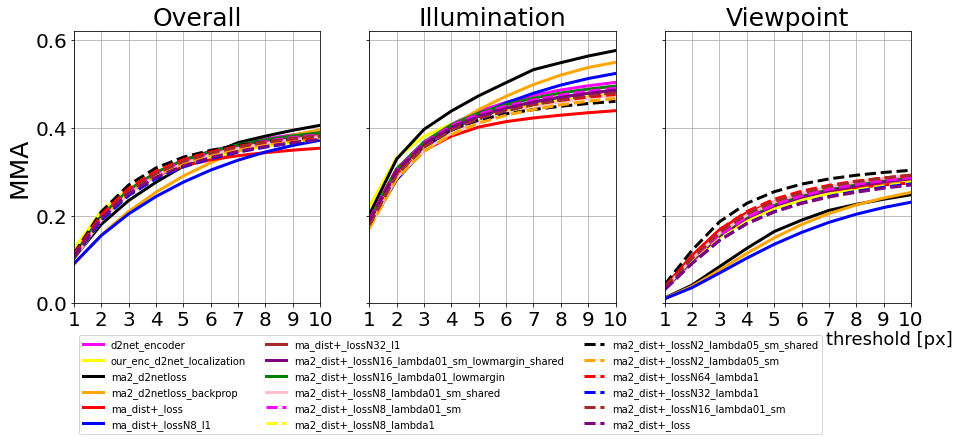

In [23]:
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=25)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [(i_err[thr] + v_err[thr]) / ((n_i + n_v) * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Overall')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylabel('MMA')
plt.ylim([0, 0.62])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)
fontP = FontProperties()
fontP.set_size('medium')
plt.legend(bbox_to_anchor=(0, -0.1), loc='upper left', prop=fontP,ncol=3)

plt.subplot(1, 3, 2)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [i_err[thr] / (n_i * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Illumination')
#plt.xlabel('threshold [px]')
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 0.62])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(1, 3, 3)
for method, name, color, ls in zip(methods, names, colors, linestyles):
    i_err, v_err, _ = errors[method]
    plt.plot(plt_rng, [v_err[thr] / (n_v * 5) for thr in plt_rng], color=color, ls=ls, linewidth=3, label=name)
plt.title('Viewpoint')
#plt.xlabel('threshold [px]')
plt.figtext(0.88, 0.01, "threshold [px]", ha="center", fontsize=18)
plt.xlim(plt_lim)
plt.xticks(plt_rng)
plt.ylim([0, 0.62])
plt.gca().axes.set_yticklabels([])
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=20)

if top_k is None:
    plt.savefig('hseq.pdf', bbox_inches='tight', dpi=300)
else:
    plt.savefig('hseq-top.pdf', bbox_inches='tight', dpi=300)